In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import random

seed = 42  # 任意の整数値
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [61]:
df = pd.read_csv("/content/drive/MyDrive/time-series-prediction/stock_price.csv")
df['日付け'] = pd.to_datetime(df['日付け'], format='%Y-%m-%d', errors='coerce')
# 出来高の変換 (Mを1e6、Bを1e9に変換)
df['出来高'] = df['出来高'].replace({'M': 'e6', 'B': 'e9'}, regex=True).astype(float)
# 変化率 % の変換
df['変化率 %'] = df['変化率 %'].str.replace('%', '').astype(float)
# 日付をインデックスに設定
df.set_index('日付け', inplace=True)
# データを逆順に並べ替え
df = df.iloc[::-1].reset_index(drop=False)

def label_change_rate(rate):
  if rate >= 0:
    return 1
  else:
    return 0

df['ラベル'] = df['変化率 %'].apply(label_change_rate)

# RSIの計算関数
def calculate_rsi(data, period=14):
    delta = data['終値'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


# RSIを追加
df['RSI'] = calculate_rsi(df)
df['rsi_overbought'] = (df['RSI'] >= 70).astype(int)
df['rsi_oversold'] = (df['RSI'] <= 30).astype(int)

df['O-C'] = df['始値'] - df['終値']
df['H-L'] = df['高値'] - df['安値']
# SMAの計算
df['sma5'] = df['終値'].rolling(window=5).mean()
df['sma10'] = df['終値'].rolling(window=10).mean()
df['sma15'] = df['終値'].rolling(window=15).mean()
df['sma20'] = df['終値'].rolling(window=20).mean()
df['sma30'] = df['終値'].rolling(window=30).mean()
df['sma50'] = df['終値'].rolling(window=50).mean()
df['sma80'] = df['終値'].rolling(window=80).mean()
df['sma100'] = df['終値'].rolling(window=100).mean()
df['sma200'] = df['終値'].rolling(window=200).mean()

# SMA比率の計算
df['sma5_ratio'] = df['終値'] / df['sma5']
df['sma10_ratio'] = df['終値'] / df['sma10']
df['sma15_ratio'] = df['終値'] / df['sma15']
df['sma20_ratio'] = df['終値'] / df['sma20']
df['sma30_ratio'] = df['終値'] / df['sma30']
df['sma50_ratio'] = df['終値'] / df['sma50']
df['sma80_ratio'] = df['終値'] / df['sma80']
df['sma100_ratio'] = df['終値'] / df['sma100']
df['sma200_ratio'] = df['終値'] / df['sma200']

# ATRの計算
df['high_low'] = df['高値'] - df['安値']
df['high_close'] = np.abs(df['高値'] - df['終値'].shift())
df['low_close'] = np.abs(df['安値'] - df['終値'].shift())
df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
df['atr'] = df['tr'].rolling(window=14).mean()

# ボラティリティ (20日の標準偏差)
df['volatility'] = df['終値'].rolling(window=20).std()

# CCIの計算
typical_price = (df['高値'] + df['安値'] + df['終値']) / 3
df['cci'] = (typical_price - typical_price.rolling(window=20).mean()) / (0.015 * typical_price.rolling(window=20).std())

# ボリンジャーバンドの計算
df['bol_mid'] = df['終値'].rolling(window=20).mean()
df['bol_upper'] = df['bol_mid'] + (df['終値'].rolling(window=20).std() * 2)
df['bol_lower'] = df['bol_mid'] - (df['終値'].rolling(window=20).std() * 2)

# OBVの計算
df['obv'] = (np.sign(df['終値'].diff()) * df['出来高']).fillna(0).cumsum()

# ROCの計算 (10日間の変化率)
df['roc2'] = df['終値'].pct_change(periods=2) * 100
df['roc3'] = df['終値'].pct_change(periods=3) * 100
df['roc4'] = df['終値'].pct_change(periods=4) * 100
df['roc5'] = df['終値'].pct_change(periods=5) * 100

# MACDの計算
ema12 = df['終値'].ewm(span=12, adjust=False).mean()
ema26 = df['終値'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()
# macd_diffの計算 (MACDとSignalの差)
df['macd_diff'] = df['macd'] - df['signal']

In [62]:
# 全てのfloat64列をfloat32に変換
df = df.astype({col: 'float32' for col in df.select_dtypes(include='float64').columns})
df = df.dropna()
df = df[df['日付け'] >= pd.to_datetime('2014-01-01') ]
df.set_index('日付け', inplace=True)

import yfinance as yf

# 米ドルから円への為替レート (USD/JPY)
ticker = 'JPY=X'
data = yf.download(ticker, start='1987-01-01', end='2024-08-02')

# 前日比で終値が何%増減したかを計算する
data['Pct_Change'] = data['Close'].pct_change() * 100

# 為替データのClose,Pct_Change列のみ抽出
exchange_close = data[['Close','Pct_Change']].rename(columns={'Close': 'Exchange_Close', 'Pct_Change': 'Exchange_Pct_Change'})

# 株価データと為替データを日付でマージ (inner join)
merged_data = df.join(exchange_close, how='inner')

#結果の確認
print(merged_data.head())



[*********************100%***********************]  1 of 1 completed

                   終値         始値         高値         安値          出来高  変化率 %  \
2014-01-06  55.700001  56.900002  57.200001  55.099998  341590016.0  -1.59   
2014-01-07  55.299999  55.500000  56.099998  55.099998  233260000.0  -0.72   
2014-01-08  56.900002  55.900002  56.900002  55.400002  260250000.0   2.89   
2014-01-09  56.200001  56.799999  56.799999  55.700001  254340000.0  -1.23   
2014-01-10  56.599998  55.799999  56.700001  55.599998  269700000.0   0.71   

            ラベル        RSI  rsi_overbought  rsi_oversold  ...           obv  \
2014-01-06    0  69.565216               0             0  ...  4.481333e+10   
2014-01-07    0  64.444443               0             0  ...  4.458007e+10   
2014-01-08    1  64.044945               0             0  ...  4.484032e+10   
2014-01-09    0  65.517242               0             0  ...  4.458598e+10   
2014-01-10    1  59.459461               0             0  ...  4.485568e+10   

                roc2      roc3      roc4      roc5      

In [63]:
train_data = merged_data[merged_data.index < '2022-08-01']
valid_data = merged_data[(merged_data.index >= '2022-08-01') & (merged_data.index < '2023-08-01')]
test_data = merged_data[merged_data.index >= '2023-08-01']

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2090, 50)
(246, 50)
(247, 50)


In [64]:

def create_sequences(data_X, X, data_y, seq_length,isTrain):
    Xs, ys = [], []
    for i in range(seq_length, len(data_X)):
        if(isTrain):
          if X[i][1] >= 0.3 or X[i][1] <= -0.3:
            Xs.append(data_X[i - seq_length:i])
            ys.append(data_y[i])
          else:
            continue
        else:
          Xs.append(data_X[i - seq_length:i])
          ys.append(data_y[i])

    return np.array(Xs), np.array(ys)

#features = ['終値', '変化率 %','Exchange_Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']
#features = ['終値','変化率 %', 'Close']
#features = ['終値', '変化率 %','Close','始値','高値','安値','出来高']
#features = ['終値', '変化率 %','Exchange_Close','H-L','Exchange_Pct_Change','O-C','roc2','RSI','sma5']
#features = ['終値', '変化率 %','Exchange_Pct_Change','H-L','O-C','roc2','RSI','bol_upper','bol_lower']
#features = ['終値', '変化率 %','Exchange_Pct_Change','H-L','O-C','RSI','obv']
#features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv','Exchange_Close','Exchange_Pct_Change']
features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv']

train_data_X = train_data[features].values
valid_data_X = valid_data[features].values
test_data_X = test_data[features].values
train_target = train_data['ラベル'].values
valid_target = valid_data['ラベル'].values
test_target = test_data['ラベル'].values

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_X)
valid_data_scaled = scaler.transform(valid_data_X)
test_data_scaled = scaler.transform(test_data_X)


seq_length = 5
train_X_seq, train_y_seq = create_sequences(train_data_scaled,train_data_X,train_target, seq_length,False)
valid_X_seq, valid_y_seq = create_sequences(valid_data_scaled,valid_data_X, valid_target,seq_length,False)
test_X_seq, test_y_seq = create_sequences(test_data_scaled,test_data_X, test_target,seq_length,False)
# PyTorchのテンソルに変換
X_train = torch.tensor(train_X_seq, dtype=torch.float32)
y_train = torch.tensor(train_y_seq, dtype=torch.long)
X_valid = torch.tensor(valid_X_seq, dtype=torch.float32)
y_valid = torch.tensor(valid_y_seq, dtype=torch.long)
X_test = torch.tensor(test_X_seq, dtype=torch.float32)
y_test = torch.tensor(test_y_seq, dtype=torch.long)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)
# 訓練データとテストデータの分割 (80%を訓練データに)
# train_size = int(len(X_seq) * 0.7)
# train_valid_size = int(len(X_seq) * 0.8)
# test_size = len(X_seq) - train_valid_size

# X_train = X_seq[:train_size]
# X_valid = X_seq[train_size:train_valid_size]
# X_test = X_seq[train_valid_size:]
# y_train = y_seq[:train_size]
# y_valid = y_seq[train_size:train_valid_size]
# y_test = y_seq[train_valid_size:]

torch.Size([2085, 5, 10])
torch.Size([2085])
torch.Size([241, 5, 10])
torch.Size([241])
torch.Size([242, 5, 10])
torch.Size([242])


In [65]:
class LSTMModel2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 最後のタイムステップの出力
        out = self.fc(out)  # 出力層
        return out

# ハイパーパラメータ
input_size = X_train.shape[2]  # 特徴量の数
hidden_size = 64  # LSTMの隠れ層の次元
output_size = 2  # 出力は2つ
num_layers = 3  # LSTM層の数
num_epochs = 600
learning_rate = 0.001

# モデルのインスタンス化
model2 = LSTMModel2(input_size, hidden_size, output_size, num_layers=num_layers)
criterion = nn.CrossEntropyLoss()

# ハイパーパラメータの探索

In [67]:
# ハイパーパラメータ候補を指定
param_grid = {
    'hidden_size': [16, 32, 64,128],
    'learning_rate': [0.01, 0.001, 0.0001],
    'num_epochs': [1000],
    'num_layers': [1,2,3,4]
}

# ランダムにパラメータを選ぶ
def get_random_params(param_grid):
    return {key: random.choice(values) for key, values in param_grid.items()}

best_accuracy = 0.0
best_params = None
best_epoch = 0

# 10回のランダムサーチを実施
for trial in range(10):
    params = get_random_params(param_grid)

    # ハイパーパラメータをセット
    hidden_size = params['hidden_size']
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    num_layers = params['num_layers']

    print(f'Trial {trial+1} with params: {params}')

    # モデルの定義
    model = LSTMModel2(input_size, hidden_size, output_size,num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 訓練とテスト
    for epoch in range(num_epochs):
        model.train()
        output_train = model(X_train)
        loss_train = criterion(output_train, y_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}')
            # テスト評価
            model.eval()
            with torch.no_grad():
                output_valid = model(X_valid)
                predicted_valid = torch.argmax(output_valid, axis=1)
                accuracy_valid = (predicted_valid == y_valid).sum().item() / y_valid.size(0)

            # ベストパラメータを保存
            if accuracy_valid > best_accuracy:
                best_accuracy = accuracy_valid
                best_params = params
                best_epoch = epoch



    print(f'Trial {trial+1} Accuracy: {accuracy_valid:.4f}, Best Accuracy so far: {best_accuracy:.4f}')

print(f'Best parameters: {best_params}, Best accuracy: {best_accuracy:.4f}, Best epoch: {best_epoch}')

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Epoch [20/1000], Train Loss: 0.6918
Epoch [40/1000], Train Loss: 0.6917
Epoch [60/1000], Train Loss: 0.6911
Epoch [80/1000], Train Loss: 0.6879
Epoch [100/1000], Train Loss: 0.6834
Epoch [120/1000], Train Loss: 0.6792
Epoch [140/1000], Train Loss: 0.6791
Epoch [160/1000], Train Loss: 0.6630
Epoch [180/1000], Train Loss: 0.6463
Epoch [200/1000], Train Loss: 0.6275
Epoch [220/1000], Train Loss: 0.5954
Epoch [240/1000], Train Loss: 0.5638
Epoch [260/1000], Train Loss: 0.4918
Epoch [280/1000], Train Loss: 0.4561
Epoch [300/1000], Train Loss: 0.3821
Epoch [320/1000], Train Loss: 0.3544
Epoch [340/1000], Train Loss: 0.2773
Epoch [360/1000], Train Loss: 0.2506
Epoch [380/1000], Train Loss: 0.1713
Epoch [400/1000], Train Loss: 0.3188
Epoch [420/1000], Train Loss: 0.1509
Epoch [440/1000], Train Loss: 0.1116
Epoch [460/1000], Train Loss: 0.0869
Epoch [480/1000], Train Loss: 0.0685
Epoch [500/1000

# 検証3 2014 ~ 過去5個　変化率0.3未満消去
## features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv']

Trial 1 with params: {'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 3}
Trial 1 Accuracy: 0.5270, Best Accuracy so far: 0.5851

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 2 Accuracy: 0.5560, Best Accuracy so far: 0.5851

Trial 3 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 3 Accuracy: 0.5228, Best Accuracy so far: 0.5851

Trial 4 with params: {'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 4 Accuracy: 0.4689, Best Accuracy so far: 0.5851

Trial 5 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 5 Accuracy: 0.4855, Best Accuracy so far: 0.5851

Trial 6 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 6 Accuracy: 0.4730, Best Accuracy so far: 0.5851

Trial 7 with params: {'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 1}
Trial 7 Accuracy: 0.5145, Best Accuracy so far: 0.5851

Trial 8 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 8 Accuracy: 0.5187, Best Accuracy so far: 0.5851

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 2}
Trial 9 Accuracy: 0.5062, Best Accuracy so far: 0.5934

Trial 10 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 10 Accuracy: 0.5270, Best Accuracy so far: 0.5934
Best parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 2}, Best accuracy: 0.5934, Best epoch: 359


# 検証2 2014~ 過去5個
## features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv','Exchange_Close','Exchange_Pct_Change']

Trial 1 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.5975, Best Accuracy so far: 0.5975

Trial 2 with params: {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 2 Accuracy: 0.5353, Best Accuracy so far: 0.5975

Trial 3 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 3 Accuracy: 0.5104, Best Accuracy so far: 0.5975

Trial 4 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 4 Accuracy: 0.5477, Best Accuracy so far: 0.5975

Trial 5 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 5 Accuracy: 0.5394, Best Accuracy so far: 0.5975

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 6 Accuracy: 0.5228, Best Accuracy so far: 0.6266

Trial 7 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 7 Accuracy: 0.5560, Best Accuracy so far: 0.6307

Trial 8 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 8 Accuracy: 0.6017, Best Accuracy so far: 0.6307

Trial 9 with params: {'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 9 Accuracy: 0.5685, Best Accuracy so far: 0.6307

Trial 10 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 4}
Trial 10 Accuracy: 0.5270, Best Accuracy so far: 0.6307
Best parameters: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}, Best accuracy: 0.6307, Best epoch: 279

# 検証1 2014~ 過去5個
## features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 1 Accuracy: 0.5643, Best Accuracy so far: 0.5768

Trial 2 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 2 Accuracy: 0.5062, Best Accuracy so far: 0.5768

Trial 3 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 3 Accuracy: 0.5311, Best Accuracy so far: 0.5768

Trial 4 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 4 Accuracy: 0.5187, Best Accuracy so far: 0.5768

Trial 5 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 1}
Trial 5 Accuracy: 0.5519, Best Accuracy so far: 0.5768

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 6 Accuracy: 0.4772, Best Accuracy so far: 0.5768

Trial 7 with params: {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 7 Accuracy: 0.4855, Best Accuracy so far: 0.5768

Trial 8 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 4}
Trial 8 Accuracy: 0.4896, Best Accuracy so far: 0.5768

Trial 9 with params: {'hidden_size': 16, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 4}
Trial 9 Accuracy: 0.5477, Best Accuracy so far: 0.5768

Trial 10 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 10 Accuracy: 0.5436, Best Accuracy so far: 0.5768
Best parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}, Best accuracy: 0.5768, Best epoch: 699


# 元モデル　すべてのデータ　過去5個
## features = ['終値','変化率 %','H-L','O-C','RSI','sma5','roc2','bol_upper','bol_lower','obv']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.5021, Best Accuracy so far: 0.5436

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 2 Accuracy: 0.4979, Best Accuracy so far: 0.5560

Trial 3 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 3 Accuracy: 0.4606, Best Accuracy so far: 0.5602

Trial 4 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 4 Accuracy: 0.5228, Best Accuracy so far: 0.5602

Trial 5 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 5 Accuracy: 0.4938, Best Accuracy so far: 0.5602

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 6 Accuracy: 0.4481, Best Accuracy so far: 0.5602

Trial 7 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 7 Accuracy: 0.5021, Best Accuracy so far: 0.5602

Trial 8 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 8 Accuracy: 0.5187, Best Accuracy so far: 0.5685

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 9 Accuracy: 0.5062, Best Accuracy so far: 0.5685

Trial 10 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 10 Accuracy: 0.5436, Best Accuracy so far: 0.5685

Best parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}, Best accuracy: 0.5685, Best epoch: 179

# 2014~ 過去5個のデータを見て予測
## features = ['終値', '変化率 %','Exchange_Close','Exchange_Pct_Change','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.5187, Best Accuracy so far: 0.5643

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 2 Accuracy: 0.5643, Best Accuracy so far: 0.6224

Trial 3 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 3 Accuracy: 0.5353, Best Accuracy so far: 0.6224

Trial 4 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 4 Accuracy: 0.5768, Best Accuracy so far: 0.6224

Trial 5 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 5 Accuracy: 0.5104, Best Accuracy so far: 0.6224

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 6 Accuracy: 0.5021, Best Accuracy so far: 0.6224

Trial 7 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 7 Accuracy: 0.5726, Best Accuracy so far: 0.6224

Trial 8 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 8 Accuracy: 0.5975, Best Accuracy so far: 0.6390

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 9 Accuracy: 0.5602, Best Accuracy so far: 0.6390

Trial 10 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 10 Accuracy: 0.5934, Best Accuracy so far: 0.6390
Best parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}, Best accuracy: 0.6390, Best epoch: 739


#2014~ 過去5個のデータを見て予測
##features = ['終値', '変化率 %','Close','始値','高値','安値','出来高']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.5768, Best Accuracy so far: 0.5768

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 2 Accuracy: 0.4979, Best Accuracy so far: 0.5768

Trial 3 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 3 Accuracy: 0.5021, Best Accuracy so far: 0.5768

Trial 4 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 4 Accuracy: 0.4357, Best Accuracy so far: 0.5934

Trial 5 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 5 Accuracy: 0.5062, Best Accuracy so far: 0.5934

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 6 Accuracy: 0.5311, Best Accuracy so far: 0.5934

Trial 7 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 7 Accuracy: 0.5021, Best Accuracy so far: 0.5934

Trial 8 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 8 Accuracy: 0.4938, Best Accuracy so far: 0.5975

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 9 Accuracy: 0.5394, Best Accuracy so far: 0.5975

Trial 10 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 10 Accuracy: 0.5311, Best Accuracy so far: 0.5975
Best parameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}, Best accuracy: 0.5975, Best epoch: 319

# 1996~ 過去10個のデータを見て予測
## features = ['終値', '変化率 %','Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

Trial 1 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.4619, Best Accuracy so far: 0.5678

Trial 2 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 2 Accuracy: 0.5297, Best Accuracy so far: 0.5678

Trial 3 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 3 Accuracy: 0.5212, Best Accuracy so far: 0.5678

Trial 4 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 4 Accuracy: 0.4703, Best Accuracy so far: 0.5678

Trial 5 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 5 Accuracy: 0.5254, Best Accuracy so far: 0.5678

Trial 6 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 6 Accuracy: 0.4788, Best Accuracy so far: 0.5678

Trial 7 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 7 Accuracy: 0.4703, Best Accuracy so far: 0.5678

Trial 8 with params: {'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 8 Accuracy: 0.4576, Best Accuracy so far: 0.5678

Trial 9 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 1}
Trial 9 Accuracy: 0.4915, Best Accuracy so far: 0.5678

Trial 10 with params: {'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 10 Accuracy: 0.4449, Best Accuracy so far: 0.5678
Best parameters: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}, Best accuracy: 0.5678, Best epoch: 299

# 1996~ 過去10個のデータを見て予測
## features = ['終値', '変化率 %','Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

# 2016~ 過去10個のデータを見て予測
## features = ['終値', '変化率 %','Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 2}
Trial 1 Accuracy: 0.4746, Best Accuracy so far: 0.5466

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 1}
Trial 2 Accuracy: 0.5254, Best Accuracy so far: 0.5636

Trial 3 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 1}
Trial 3 Accuracy: 0.5254, Best Accuracy so far: 0.5636

Trial 4 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 2}
Trial 4 Accuracy: 0.5127, Best Accuracy so far: 0.5636

Trial 5 with params: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 3}
Trial 5 Accuracy: 0.5339, Best Accuracy so far: 0.5720

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 3}
Trial 6 Accuracy: 0.5720, Best Accuracy so far: 0.5720

Trial 7 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 3}
Trial 7 Accuracy: 0.4619, Best Accuracy so far: 0.5720

Trial 8 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 1}
Trial 8 Accuracy: 0.5297, Best Accuracy so far: 0.5720

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 600, 'num_layers': 1}
Trial 9 Accuracy: 0.5000, Best Accuracy so far: 0.5720

Trial 10 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 600, 'num_layers': 4}
Trial 10 Accuracy: 0.5339, Best Accuracy so far: 0.5720
Best parameters: {'hidden_size': 128, 'learning_rate': 0.01, 'num_epochs': 600, 'num_layers': 3}, Best accuracy: 0.5720, Best epoch: 379

#2014~ 過去10個のデータを見て予測
##features = ['終値', '変化率 %','Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

Trial 1 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 2}
Trial 1 Accuracy: 0.5381, Best Accuracy so far: 0.5847

Trial 2 with params: {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 2 Accuracy: 0.5551, Best Accuracy so far: 0.5847

Trial 3 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 3 Accuracy: 0.5932, Best Accuracy so far: 0.5932

Trial 4 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 4 Accuracy: 0.5212, Best Accuracy so far: 0.5932

Trial 5 with params: {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 5 Accuracy: 0.6271, Best Accuracy so far: 0.6271

Trial 6 with params: {'hidden_size': 16, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 2}
Trial 6 Accuracy: 0.5424, Best Accuracy so far: 0.6271

Trial 7 with params: {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 4}
Trial 7 Accuracy: 0.4576, Best Accuracy so far: 0.6271



Best parameters: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 600, 'num_layers': 1}, Best accuracy: 0.6100, Best epoch: 419


# 2014~データすべて用いる 過去5個のデータを見て予測

##features = ['終値', '変化率 %','Close','H-L','O-C','roc2','RSI','bol_upper','bol_lower']

Trial 1 with params: {'hidden_size': 16, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 3}
Trial 1 Accuracy: 0.5353, Best Accuracy so far: 0.5851

Trial 2 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 1}
Trial 2 Accuracy: 0.5726, Best Accuracy so far: 0.5851

Trial 3 with params: {'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 3 Accuracy: 0.5934, Best Accuracy so far: 0.6017

Trial 4 with params: {'hidden_size': 16, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 4}
Trial 4 Accuracy: 0.5975, Best Accuracy so far: 0.6017

Trial 5 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 3}
Trial 5 Accuracy: 0.5726, Best Accuracy so far: 0.6017

Trial 6 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 1}
Trial 6 Accuracy: 0.5560, Best Accuracy so far: 0.6017

Trial 7 with params: {'hidden_size': 32, 'learning_rate': 0.0001, 'num_epochs': 1000, 'num_layers': 2}
Trial 7 Accuracy: 0.5436, Best Accuracy so far: 0.6017

Trial 8 with params: {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}
Trial 8 Accuracy: 0.6017, Best Accuracy so far: 0.6307

Trial 9 with params: {'hidden_size': 64, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1}
Trial 9 Accuracy: 0.5477, Best Accuracy so far: 0.6307

Trial 10 with params: {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 1}
Trial 10 Accuracy: 0.5602, Best Accuracy so far: 0.6307

Best parameters: {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 1000, 'num_layers': 2}, Best accuracy: 0.6307, Best epoch: 479

In [58]:
# ハイパーパラメータ
input_size = X_train.shape[2]  # 特徴量の数
hidden_size = 64   # LSTMの隠れ層の次元
output_size = 2  # 出力は2つ
num_layers = 2  # LSTM層の数
num_epochs = 360
learning_rate = 0.0001
# モデルのインスタンス化
best_model = LSTMModel2(input_size, hidden_size, output_size, num_layers=num_layers)
# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=learning_rate)

# モデルの訓練
for epoch in range(num_epochs):
    best_model.train()  # 訓練モードに切り替え

    # 訓練データで順伝播
    output_train = best_model(X_train)  # LSTMの出力を取得
    loss_train = criterion(output_train, y_train)  # 訓練データの損失を計算

    # 逆伝播とパラメータの更新
    optimizer.zero_grad()  # 勾配の初期化
    loss_train.backward()  # 勾配の計算
    optimizer.step()  # パラメータの更新

    # 進捗を表示
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss_train.item():.4f}')
        with torch.no_grad():  # 勾配計算をしない
          output_val = best_model(X_valid)  # validationデータでの推論
          loss_val = criterion(output_val, y_valid)  # validationデータの損失を計算

          # 予測とaccuracyの計算（validation）
          _, predicted_val = torch.max(output_val, 1)
          correct_val = (predicted_val == y_valid).sum().item()
          accuracy_val = correct_val / y_valid.size(0)
          print(f'Validation Accuracy: {accuracy_val:.4f}')
          print(f'Validation Loss: {loss_val.item():.4f}')

          output_test = best_model(X_test)  # testデータでの推論
          _, predicted_test = torch.max(output_test, 1)
          correct_test = (predicted_test == y_test).sum().item()
          accuracy_test = correct_test / y_test.size(0)
          print(f'Test Accuracy: {accuracy_test:.4f}')

          output_train = best_model(X_train)  # trainデータでの推論
          _, predicted_train = torch.max(output_train, 1)
          correct_train = (predicted_train == y_train).sum().item()
          accuracy_train = correct_train / y_train.size(0)
          print(f'Train Accuracy: {accuracy_train:.4f}')


best_model.eval()
with torch.no_grad():
    output_test = best_model(X_test)
    predicted_test = torch.argmax(output_test, axis=1)
    accuracy_test = (predicted_test == y_test).sum().item() / y_test.size(0)
    output_train = best_model(X_train)
    predicted_train = torch.argmax(output_train, axis=1)
    accuracy_train = (predicted_train == y_train).sum().item() / y_train.size(0)

print(f'test Accuracy: {accuracy_test:.4f}  train Accuracy: {accuracy_train:.4f}')

Epoch [20/360], Train Loss: 0.6933
Validation Accuracy: 0.5311
Validation Loss: 0.6917
Test Accuracy: 0.5207
Train Accuracy: 0.5048
Epoch [40/360], Train Loss: 0.6931
Validation Accuracy: 0.5311
Validation Loss: 0.6928
Test Accuracy: 0.5248
Train Accuracy: 0.5048
Epoch [60/360], Train Loss: 0.6930
Validation Accuracy: 0.5436
Validation Loss: 0.6930
Test Accuracy: 0.4917
Train Accuracy: 0.5048
Epoch [80/360], Train Loss: 0.6930
Validation Accuracy: 0.5602
Validation Loss: 0.6929
Test Accuracy: 0.4752
Train Accuracy: 0.5042
Epoch [100/360], Train Loss: 0.6930
Validation Accuracy: 0.5270
Validation Loss: 0.6930
Test Accuracy: 0.4380
Train Accuracy: 0.5078
Epoch [120/360], Train Loss: 0.6929
Validation Accuracy: 0.4689
Validation Loss: 0.6932
Test Accuracy: 0.4876
Train Accuracy: 0.5024
Epoch [140/360], Train Loss: 0.6929
Validation Accuracy: 0.4689
Validation Loss: 0.6934
Test Accuracy: 0.5041
Train Accuracy: 0.5114
Epoch [160/360], Train Loss: 0.6928
Validation Accuracy: 0.4689
Validatio

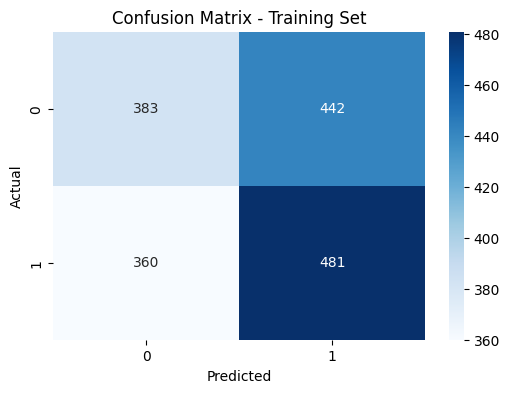

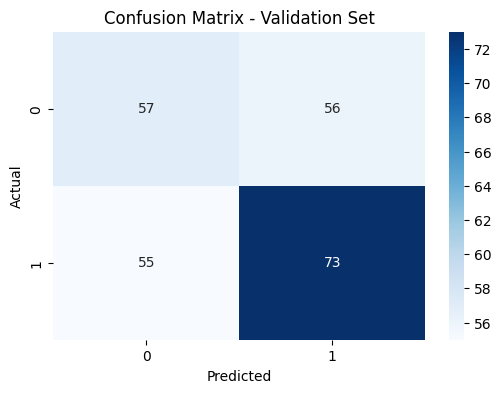

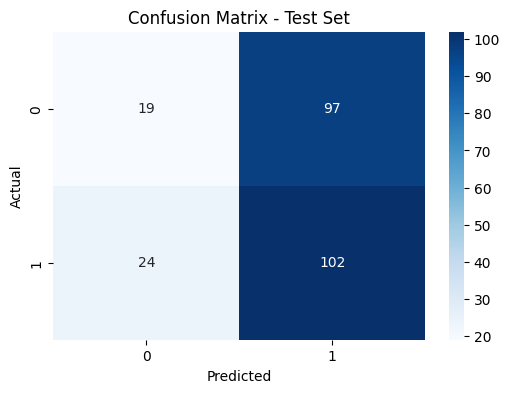

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# トレーニングデータに対する予測を取得
best_model.eval()
with torch.no_grad():
    # トレーニングデータの予測値
    predicted_train = torch.argmax(best_model(X_train), axis=1).detach().numpy()
    predicted_valid = torch.argmax(best_model(X_valid), axis=1).detach().numpy()
    predicted_test = torch.argmax(best_model(X_test), axis=1).detach().numpy()

# トレーニングデータの混同行列を計算・表示
train_cm = confusion_matrix(y_train, predicted_train)
plt.figure(figsize=(6, 4))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#検証データの混同行列を計算・表示
valid_cm = confusion_matrix(y_valid, predicted_valid)
plt.figure(figsize=(6, 4))
sns.heatmap(valid_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# テストデータの混同行列を計算・表示
test_cm = confusion_matrix(y_test, predicted_test)
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

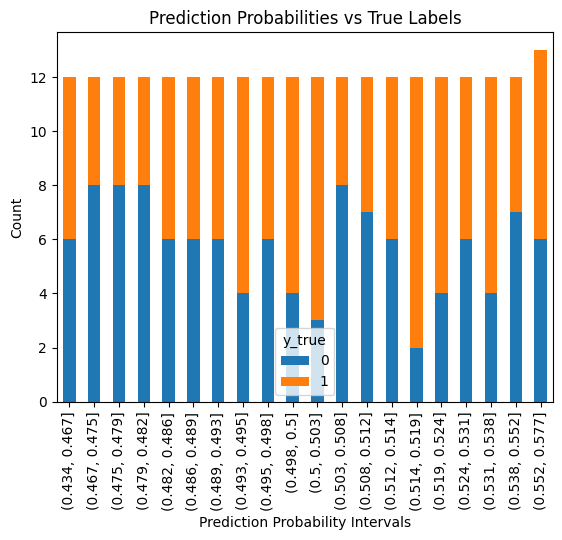

In [20]:
# Softmaxを使って確率を取得
best_model.eval()
with torch.no_grad():
    predicted_train_probs = torch.softmax(best_model(X_train), axis=1).detach().numpy()  # 確率
    predicted_test_probs = torch.softmax(best_model(X_test), axis=1).detach().numpy()  # 確率

# X_testの最後のタイムステップのみを抽出
X_test_last_step = X_test[:, -1, :].numpy()

# pandas DataFrameに変換
X_test_df = pd.DataFrame(X_test_last_step, columns=features)

# 真のラベル（y_test）を追加
X_test_df['y_true'] = y_test.numpy()

# 予測確率を取得（クラス1の確率）
y_pred = predicted_test_probs[:, 1]  # クラス1の予測確率を取得

# 確率区間を分割 (例: 5%刻み)
quantile_intervals = np.arange(0, 1.05, 0.05)
quantile_values = np.quantile(y_pred, quantile_intervals)

# 確率を区間に分割
classes = pd.cut(y_pred, quantile_values)

# 予測確率の区間ごとに、真のラベルをクロス集計
pred_table = pd.crosstab(classes, X_test_df['y_true'])

# ヒストグラムをプロット
pred_table.plot(kind="bar", stacked=True, rot=90)
plt.title("Prediction Probabilities vs True Labels")
plt.xlabel("Prediction Probability Intervals")
plt.ylabel("Count")
plt.show()